In [1]:
# !pip install cupy

In [2]:
# import cupy as np
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
# Load data from different CSV files
transactions_df = pd.read_csv("../dataset/transactions_train.csv")
submission_df = pd.read_csv('../dataset/sample_submission.csv')
text_article_ids = np.load('text_articles.npy')

In [4]:
def get_most_bought_articles(data, num_articles=5):
    # Create dataframe that contains the number of times each article has been bought
    articles_counts = data[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})
    articles_counts = articles_counts.sort_values(by='count', ascending=False)
    most_bought_articles = articles_counts.loc[articles_counts['count'] >= num_articles]['article_id'].values
    return most_bought_articles

In [5]:
# Create training dataset with positive examples.
# The training data will contain all transactions starting from 01/07/2020.
# Only items that have been bought at least 40 times will be kept. Also, we
# are only going to compute the information for the customers that appear
# in these transactions. 

# Removes articles that do not have corresponding images
m = 40

start_date = pd.to_datetime('2020-07-01')

filtered_transactions_df = transactions_df.copy()
filtered_transactions_df.t_dat = pd.to_datetime(filtered_transactions_df.t_dat)
filtered_transactions_df = filtered_transactions_df.loc[filtered_transactions_df.t_dat >= start_date]

train_df = filtered_transactions_df.copy()

most_bought_articles = get_most_bought_articles(train_df, num_articles=m)

import os
img_root = "../dataset/images"
articles_with_img = []
for path, subdirs, files in os.walk(img_root):
    for name in files:
        articles_with_img.append(int(name.split(".")[0]))
articles_with_img = np.array(articles_with_img)

print("Articles that have images: ",len(articles_with_img))
print("Articles that have text description: ",len(text_article_ids))

for article in most_bought_articles:
    if (article not in articles_with_img) or (article not in text_article_ids):
        most_bought_articles = most_bought_articles[most_bought_articles != article] 

most_bought_articles = np.sort(most_bought_articles)

train_df = train_df.drop(train_df.loc[~train_df.article_id.isin(most_bought_articles)].index)
filtered_transactions_df = filtered_transactions_df.drop(filtered_transactions_df.loc[~filtered_transactions_df.article_id.isin(most_bought_articles)].index)

recent_customers = train_df.loc[train_df.article_id.isin(most_bought_articles)].customer_id.unique()
recent_customers = np.random.choice(recent_customers, size = 13720)
recent_customers = np.sort(recent_customers)
train_df = train_df[train_df.customer_id.isin(recent_customers)]
num_articles = len(most_bought_articles)
num_customers = len(recent_customers)
print("Num of articles:",num_articles)
print("Num of customers:",num_customers)

Articles that have images:  105100
Articles that have text description:  104297
Num of articles: 12830
Num of customers: 13720


In [6]:
# Train and Validation Split
# filtered_df = train_df.groupby('customer_id').count().sort_values(by = 't_dat')
# filtered_df = filtered_df[filtered_df['t_dat']> 5]
# print("No. of Customers:",len(filtered_df.index))
# train_df.set_index('customer_id', inplace= True)
# train_df = train_df.loc[filtered_df.index.values]
# train_df.reset_index(inplace= True)

In [7]:
train_df

,t_dat,customer_id,article_id,price,sales_channel_id
28401481,2020-07-01,009f4e304a83016f8d7e48b9669791e26cfb25932e6365...,895098001,0.015525,1
28401482,2020-07-01,009f4e304a83016f8d7e48b9669791e26cfb25932e6365...,160442007,0.012407,1
28401483,2020-07-01,009f4e304a83016f8d7e48b9669791e26cfb25932e6365...,883033002,0.031051,1
28401484,2020-07-01,009f4e304a83016f8d7e48b9669791e26cfb25932e6365...,887770001,0.015525,1
28401569,2020-07-01,010713a56d4c0126e8e218f80d31ff4a42873ef41b6040...,832361003,0.015237,1
...,...,...,...,...,...
31787799,2020-09-22,fb3cb15d47ea95b54486c1f3a5d953e35a59b4b993d428...,837249024,0.016932,2
31787800,2020-09-22,fb3cb15d47ea95b54486c1f3a5d953e35a59b4b993d428...,794191004,0.022017,2
31788212,2020-09-22,fed45562e3ee9bb772ea2aa06dd2335f93a1ef351fb9f9...,506098007,0.023712,1
31788289,2020-09-22,ff813df6887c2a6d7065aed247bf1db3d6f629eee23798...,907702003,0.016932,1


In [8]:
# Create dictionaries with mapping keys
articles_id_to_idx = dict(zip(most_bought_articles, range(num_articles)))
customers_id_to_idx = dict(zip(recent_customers, range(num_customers)))

train_df = train_df.loc[train_df['article_id'].isin(most_bought_articles)]
train_df = train_df[['customer_id', 'article_id']]

train_df['article_id'] = train_df['article_id'].apply(lambda x: articles_id_to_idx[x])
train_df['customer_id'] = train_df['customer_id'].apply(lambda x: customers_id_to_idx[x])

train_df = train_df.reset_index()
train_df = train_df.drop('index', axis= 1)
train_df = train_df.set_index('customer_id')

train_df

,article_id
customer_id,
29,10832
29,24
29,9900
29,10231
46,6018
...,...
13497,6282
13497,4172
13661,420


In [9]:
img_embeddings = np.load('../rwang97/features.npy')
text_embeddings = np.load('text_embeddings.npy')
print("Text Embeddings shape: ",text_embeddings.shape)
print("Image embeddings shape: ",img_embeddings.shape)

Text Embeddings shape:  (104297, 384)
Image embeddings shape:  (105100, 1000)


In [10]:
img_paths = np.load("../rwang97/img_path.pickle", allow_pickle=True)
img_paths = [p.replace("/cs282/shared/h-and-m-personalized-fashion-recommendations/images/", "") for p in img_paths]
img_paths = [p.replace(".jpg", "") for p in img_paths]
img_paths = [int(p.split("/")[1]) for p in img_paths]

In [11]:
img_paths_to_idx =  dict(zip(img_paths, range(len(img_paths))))
text_paths_to_idx = dict(zip(text_article_ids,range(len(text_article_ids))))

In [12]:
filtered_embeddings = []
for article in most_bought_articles:
    filtered_embeddings.append(img_embeddings[img_paths_to_idx[article]])
filtered_embeddings = np.array(filtered_embeddings)
print(filtered_embeddings.shape)

(12830, 1000)


In [13]:
filtered_text_embeddings = []
for article in most_bought_articles:
    filtered_text_embeddings.append(text_embeddings[text_paths_to_idx[article]])
filtered_text_embeddings = np.array(filtered_text_embeddings)
print(filtered_text_embeddings.shape)

(12830, 384)


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
item_similarity = cosine_similarity(filtered_embeddings)
print(item_similarity.shape)

(12830, 12830)


In [15]:
item_text_similarity = cosine_similarity(filtered_text_embeddings)
print(item_text_similarity.shape)

(12830, 12830)


In [16]:
item_similarity_i = np.copy(item_similarity)
for i in range(len(item_similarity_i)):
    item_similarity_i[i][i] = -1

In [17]:
item_text_similarity_i = np.copy(item_text_similarity)
for i in range(len(item_text_similarity_i)):
    item_text_similarity_i[i][i] = -1

In [18]:
# Now sort the item similarity matrix, get top 12 similar items for each item and then for each customer in train df generate recommendations

In [19]:
similar_items = np.argsort(-item_similarity_i)
print(similar_items)
# Retain only top 12 similar items for each item
top_12 = similar_items[:,:12]

[[ 3533  2381  3537 ...   975  2875     0]
 [12480  7671 12065 ...  7477  6545     1]
 [  194   511   277 ...  4593 12004     2]
 ...
 [ 6720 10416  9176 ...  7212  4703 12827]
 [ 8975 11446  9906 ...  3272  8660 12828]
 [  730    41  4480 ...  8662 10457 12829]]


In [20]:
similar_text_items = np.argsort(-item_text_similarity_i)
print(similar_text_items)
# Retain only top 12 similar items for each item
top_12_text = similar_text_items[:,:12]

[[  213   214 12725 ...  7558  7557     0]
 [   19    13    12 ...  1554  1553     1]
 [ 1564   552   551 ...  8979  8978     2]
 ...
 [12828  5110  5108 ... 11041 11042 12827]
 [12827  5110  5108 ... 11042 11041 12828]
 [  173    53    50 ...  1554  1553 12829]]


In [21]:
joined_art_df = train_df.reset_index().groupby(['customer_id']).agg(set).applymap(list).reset_index().rename(columns = {'article_id': 'bought_articles'})
joined_art_df.set_index('customer_id',inplace= True)
joined_art_df['bought_articles_count'] = joined_art_df['bought_articles'].apply(len)
display(joined_art_df)

,bought_articles,bought_articles_count
customer_id,,
0,[9110],1
1,"[8506, 5820]",2
2,"[10630, 14, 5242, 5243, 701, 1055]",6
3,"[2500, 2501, 109, 4398, 661, 2264]",6
4,"[8836, 8837]",2
...,...,...
13715,"[772, 12093, 2431]",3
13716,"[2004, 1113, 6203, 2813, 1246]",5
13717,"[313, 8236, 7855, 4111, 9778, 3288, 5241, 2232]",8


In [22]:
joined_art_df.sort_values(by = 'bought_articles_count', ascending= False)

,bought_articles,bought_articles_count
customer_id,,
3489,"[7681, 5121, 5127, 3602, 3603, 535, 5145, 5658...",141
2145,"[6660, 9229, 5647, 10767, 11794, 1051, 8736, 6...",95
10323,"[10245, 7176, 9228, 12815, 11280, 11281, 11282...",91
1053,"[10264, 11301, 7717, 11303, 7720, 4664, 10818,...",77
11403,"[7554, 1019, 11550, 12299, 10381, 4878, 10897,...",76
...,...,...
5664,[11243],1
5663,[6498],1
5655,[11526],1


In [65]:
d = {str(1):100,'2':200}
x = pd.Series(d)
print(' '.join(list(x.sort_values(ascending= False).index[:2].values)))

2 1


In [67]:
def find_top_12_items(x,top_12,item_similarity_i):
    item_dict = {}
    for idx in x:
        elements = top_12[idx]
        for y in elements:
            item_dict[str(img_paths[y])] = max(item_dict.get(str(img_paths[y]),-1),item_similarity_i[idx,y])
    return ' '.join(list(pd.Series(item_dict).sort_values(ascending= False).index[:12].values))

In [66]:
def find_top_12_text_items(x,top_12_text,item_text_similarity_i):
    item_dict = {}
    for idx in x:
        elements = top_12_text[idx]
        for y in elements:
            item_dict[str(text_article_ids[y])] = max(item_dict.get(str(text_article_ids[y]),-1),item_text_similarity_i[idx,y])
    return ' '.join(list(pd.Series(item_dict).sort_values(ascending= False).index[:12].values))

In [68]:
joined_art_df['prediction'] = joined_art_df['bought_articles'].apply(lambda x: find_top_12_items(x,top_12,item_similarity_i))

In [69]:
joined_art_df['text_prediction'] = joined_art_df['bought_articles'].apply(lambda x: find_top_12_items(x,top_12_text,item_text_similarity_i))

In [40]:
joined_art_df.reset_index(inplace = True)

In [57]:
joined_art_df['customer_id'] = joined_art_df.customer_id.apply(lambda x: recent_customers[x])

In [70]:
joined_art_df

,customer_id,bought_articles,bought_articles_count,prediction,text_prediction
0,0025d25c40540d5540d1c42252dcd2c7db609d55ce731a...,[9110],1,741313002 749974001 562165002 770336001 745475...,741293001 744763001 747196002 566556003 562165...
1,002ec67719d49448f54e88e41c15b9132a84a3fccd5972...,"[8506, 5820]",2,742169003 746268001 745986002 522398057 814817...,746144009 742169003 677341001 678688003 677708...
2,003043175f4a58a208652e1d57511d2dbfeb3f3e2a43a3...,"[10630, 14, 5242, 5243, 701, 1055]",6,813330001 567818001 810270002 523479017 817274...,521779002 524825012 522803009 527517010 527487...
3,0030bed6ae85e5e4f89285f21345b5f5dd0df531ec5a76...,"[2500, 2501, 109, 4398, 661, 2264]",6,811835003 817058001 529588006 816111005 819851...,675255001 679128001 812375026 817086001 814224...
4,0033c253ee4c93f7b00e8fbaf19c645854d3362429e54f...,"[8836, 8837]",2,568458003 817067002 569984035 679494003 745698...,741417007 743909015 748928001 741806001 770253...
...,...,...,...,...,...
13531,ffe49c76a9b1ebc6fae5752ce33ba6d74bcec0766f8677...,"[772, 12093, 2431]",3,566942007 811705003 813015001 678696019 675214...,564497001 565379002 524149001 523776008 810008...
13532,fff5506ea8a342e778e4f2fbc2c9575e20b71cf24b75e6...,"[2004, 1113, 6203, 2813, 1246]",5,813613001 566592008 562677017 811720003 815446...,812746001 816832006 814512003 819947001 819866...
13533,fff673307d4cdbf688e4a0bcfe7f671036033dbe7eba01...,"[313, 8236, 7855, 4111, 9778, 3288, 5241, 2232]",8,569241001 671022001 741542001 814620006 678741...,746775001 741220013 742947002 745783001 744112...
13534,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,"[5410, 868, 7780, 431, 2903, 12537]",6,747764002 529008009 813010001 815669002 675657...,522092001 524458010 529174001 524979017 524825...


In [107]:
img_pred_df = joined_art_df[['customer_id','prediction']]
txt_pred_df = joined_art_df[['customer_id','text_prediction']].rename(columns = {'text_prediction':'prediction'})

In [74]:
default_df = pd.read_csv('../rwang97/submission.csv')

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601006 0924243001 0568597006 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0826211002 0800436010 0924243001 0739590027 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0852643001 0852643003 0858883002 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0448509014 0573085028 0924243001 0751471001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587015 0924243001 0896152002 08...


In [90]:
rem_default_df = default_df[~default_df['customer_id'].isin(joined_art_df['customer_id'])]

In [108]:
img_pred_df = pd.concat([img_pred_df,rem_default_df]).sort_values(by = 'customer_id')
txt_pred_df = pd.concat([txt_pred_df,rem_default_df]).sort_values(by = 'customer_id')

In [109]:
txt_pred_df

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601006 0924243001 0568597006 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0826211002 0800436010 0924243001 0739590027 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0852643001 0852643003 0858883002 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0448509014 0573085028 0924243001 0751471001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587015 0924243001 0896152002 08...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0804992033 0713997002 0720125039 0740922009 05...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0818754002 0762846031 0924243001 0759871030 06...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0884081001 0689365050 0762846027 0794819001 06...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0882810001 0714790020 0924243001 0448509014 04...


In [110]:
img_pred_df.to_csv('img_submission.csv',index= False)
txt_pred_df.to_csv('txt_submission.csv',index= False)

In [119]:
kmeans_12_df = pd.read_csv('kmeans_24_submission.csv')
kmeans_12_df.sort_values(by = 'customer_id',inplace= True)
kmeans_12_df.to_csv('kmeans_24_submission.csv',index=False)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'No. of Clusters K vs MAP@12')

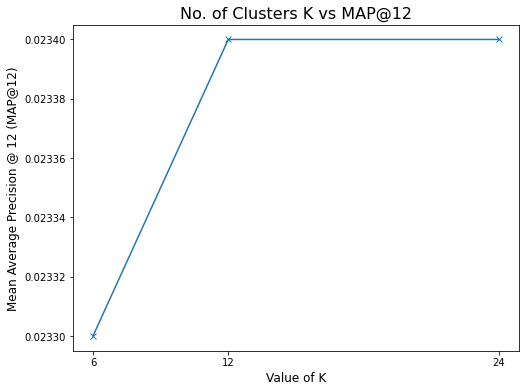

In [27]:
plt.figure(figsize = (8,6))
plt.plot([6,12,24], [0.0233,0.0234,0.0234],'x-')
plt.xticks([6,12,24])
ax = plt.gca()
ax.set_xlabel("Value of K", fontsize = 12)
ax.set_ylabel("Mean Average Precision @ 12 (MAP@12)", fontsize = 12)
ax.set_title("No. of Clusters K vs MAP@12",fontsize = 16)